# Setup

## Imports

In [80]:
from IPython.display import display
from helpers import displayAsDF, displayCols, displayVcs, pdp, vcs
import numpy as np
import pandas as pd
import pycountry_convert as pc
import matplotlib.pyplot as plt

## Configuration

In [81]:
pd.options.mode.chained_assignment = None

## Variables

In [82]:
# Downloaded from https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries
salaries = pd.read_csv("ds_salaries.csv", index_col=0)


## Helpers

In [83]:
# Min-Max Normalize
def mmn(ndarray):
  min = ndarray.min()
  return (ndarray - min)/(ndarray.max() - min)

# Adapted from https://stackoverflow.com/a/41385215
def pie_maker(total, cols):
  rows = (total // cols) + (total % cols)
  fig = plt.figure(facecolor="white", figsize=(5*cols, 4*rows))
  i = 1
  def pie(col):
    nonlocal i
    ax = fig.add_subplot(rows, cols, i)
    x = vcs(col, False)
    ax.pie(x=x, labels=x.index, autopct="%1.1f%%")
    plt.title(col.name)
    i += 1
  return pie

# Pre-processing

## Preview

In [84]:
display(salaries)
salaries.apply(displayVcs)
pdp()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


,work_year
2020,72
2021,217
2022,318


,experience_level
EN,88
EX,26
MI,213
SE,280


,employment_type
CT,5
FL,4
FT,588
PT,10


,job_title
3D Computer Vision Researcher,1
AI Scientist,7
Analytics Engineer,4
Applied Data Scientist,5
Applied Machine Learning Scientist,4
BI Data Analyst,6
Big Data Architect,1
Big Data Engineer,8
Business Data Analyst,5
Cloud Data Engineer,2


,salary
4000,2
8000,1
8760,1
9272,1
10000,2
...,...
6000000,1
7000000,2
8500000,1
11000000,2


,salary_currency
AUD,2
BRL,2
CAD,18
CHF,1
CLP,1
CNY,2
DKK,2
EUR,95
GBP,44
HUF,2


,salary_in_usd
2859,1
4000,2
5409,1
5679,1
5707,1
...,...
412000,1
416000,1
423000,1
450000,2


,employee_residence
AE,3
AR,1
AT,3
AU,3
BE,2
BG,1
BO,1
BR,6
CA,29
CH,1


,remote_ratio
0,127
50,99
100,381


,company_location
AE,3
AS,1
AT,4
AU,3
BE,2
BR,3
CA,30
CH,2
CL,1
CN,2


,company_size
L,198
M,326
S,83


## Transformation

### Integer-ize `experience_level`

In [85]:
salaries["experience_level"].replace({ "EN": 1, "MI": 2, "SE": 3, "EX": 4 }, inplace=True)

displayVcs(salaries["experience_level"])

,experience_level
1,88
2,213
3,280
4,26


### `job_title`

#### Standardize

In [86]:
salaries["job_title"].replace(r".*Researcher", "Research Scientist", regex=True, inplace=True)
salaries["job_title"].replace(r"(AI|Computer Vision|Machine Learning|NLP)", "ML", regex=True, inplace=True)
salaries["job_title"].replace(r".*(Data|ML).*(Analyst|Architect|Engineer|Researcher|Scientist).*", r"\1 \2", regex=True, inplace=True)
salaries["job_title"].replace(r"((Director|Head).*|.*(Manager))", "Manager", regex=True, inplace=True)

job_title_vcs = salaries["job_title"].value_counts()
five_pct = salaries.shape[0] / 20
salaries["job_title"][salaries["job_title"].apply(lambda jt: (job_title_vcs[jt] < five_pct))] = "Other"

job_popularities = vcs(salaries["job_title"])
displayAsDF(job_popularities)

,job_title
Data Analyst,119
Data Engineer,165
Data Scientist,159
ML Engineer,61
Manager,37
Other,66


#### Popularity Encode as `job_popularity`

In [87]:
salaries["job_popularity"] = salaries["job_title"].apply(lambda jt: job_popularities[jt])

displayVcs(salaries["job_popularity"])

,job_popularity
37,37
61,61
66,66
119,119
159,159
165,165


### Booleanize `employee_residence` as `ricl`

***Resides In `company_location`:** whether residence is in same country as company*

There are a lot of similarites between `company_location` & `employee_residence`, so this will reduce unnecessary spread

In [88]:
salaries["ricl"] = salaries["company_location"] == salaries["employee_residence"]

displayVcs(salaries["ricl"])

,ricl
False,51
True,556


### `company_location`

- Many discrete values; should be binned to reduce spread.

#### Bin by continents

In [89]:
salaries["company_location"] = salaries["company_location"].apply(pc.country_alpha2_to_continent_code)

displayVcs(salaries["company_location"])

,company_location
AF,4
AS,47
EU,157
NA,389
OC,5
SA,5


#### Integer-ize from West to East

NA, the Westmost continent, is 1; OC, the Eastmost continent, is 6

In [90]:
salaries["company_location"].replace({ "NA": 1, "SA": 2, "AF": 3, "EU": 4, "AS": 5, "OC": 6 }, inplace=True)

displayVcs(salaries["company_location"])

,company_location
1,389
2,5
3,4
4,157
5,47
6,5


### Integer-ize `company_size`

In [91]:
salaries["company_size"].replace({ "S": 1, "M": 2, "L": 3 }, inplace=True)

displayVcs(salaries["company_size"])

,company_size
1,83
2,326
3,198


### Min-Max Normalize Ordinal cols & `job_popularity`

In [92]:
ordinal_cols = ["company_location", "company_size", "experience_level", "remote_ratio", "job_popularity"]
salaries[ordinal_cols] = mmn(salaries[ordinal_cols])

salaries[ordinal_cols].describe()

,company_location,company_size,experience_level,remote_ratio,job_popularity
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,0.229654,0.594728,0.467326,0.709226,0.690563
std,0.315774,0.327010,0.261837,0.407091,0.350267
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.333333,0.500000,0.226562
50%,0.000000,0.500000,0.666667,1.000000,0.953125
75%,0.600000,1.000000,0.666667,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Drop base cols

- Base cols can be directly calculated from their derivatives, so they can be reduced for Dimensionality Reduction 
- `salary` & `salary_currency` are used to calculate `salary_in_usd`

In [93]:
salaries.drop(columns=["employee_residence", "job_title", "salary", "salary_currency"], inplace=True)

## Cleaning

### Duplicates

#### Identify

##### Across index

In [94]:
duplicate_indexes = salaries[salaries.index.duplicated(keep=False)]

display(duplicate_indexes)
print(duplicate_indexes.size)

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_location,company_size,job_popularity,ricl


0


##### Across values

In [95]:
duplicate_values = vcs(salaries[salaries.duplicated(keep=False)])

displayAsDF(duplicate_values, columns=["duplicates"])
print(duplicate_values.sum())

duplicates
work_year experience_level employment_type salary_in_usd remote_ratio company_location company_size job_popularity ricl            
2021      0.333333         FT              90734         0.5          0.6              1.0          0.953125       True           2
                                           110000        1.0          0.0              1.0          1.000000       True           2
                                           200000        1.0          0.0              1.0          1.000000       True           2
2022      0.333333         FT              32974         1.0          0.6              0.5          0.640625       True           2
                                           43966         1.0          0.6              0.5          0.640625       True           2
                                           49461         1.0          0.6              0.5          1.000000       True           2
                                           54957         0.0          0.6              0.5          0.226562       True           2
                                           58000         0.0          0.0              0.0          0.640625       True           2
                                           65949         1.0          0.6              0.5          1.000000       True           2
                                           76940         1.0          0.6              0.5          1.000000       True           2
                                           78526         1.0          0.6              0.5          1.000000       True           2
                                           87932         1.0          0.6              0.5          1.000000       True           2
          0.666667         FT              61300         1.0          0.0              0.5          0.640625       True           2
                                           90320         1.0          0.0              0.5          0.640625       True           5
                                           99000         0.0          0.0              0.5          0.640625       True           2
                                           100000        1.0          0.0              0.5          0.640625       True           2
                                                                                                    1.000000       True           2
                                           112900        1.0          0.0              0.5          0.640625       True           4
                                           115000        1.0          0.0              0.5          1.000000       True           2
                                           123000        1.0          0.0              0.5          0.953125       True           3
                                           130000        1.0          0.0              0.5          0.640625       True           2
                                                                                                    1.000000       True           2
                                           132320        1.0          0.0              0.5          1.000000       True           2
                                           135000        1.0          0.0              0.5          0.640625       True           2
                                           140000        1.0          0.0              0.5          0.953125       True           6
                                           140400        0.0          0.0              1.0          0.953125       True           2
                                           154600        1.0          0.0              1.0          1.000000       True           2
                                           155000        1.0          0.0              0.5          1.000000       True           2
                                           160000        1.0          0.0              0.5          1.000000       True           2
                             

85


#### Ignore

Based on the available cols, exact duplicates are sensible. They probably refer to employees working for the same company, in the same role.

### Missing Values (NAs)

#### Identify

There are no NAs

In [96]:
na_sum = salaries.isna().sum()
# Exclude columns without NAs
na_sum = na_sum[na_sum > 0]

displayAsDF(na_sum, columns=["NAs"])

,NAs


### Outliers

#### Identify

- The difference between `salary_in_usd`'s 3rd quartile & max is huge

In [97]:
salaries.describe()

,work_year,experience_level,salary_in_usd,remote_ratio,company_location,company_size,job_popularity
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,2021.405272,0.467326,112297.869852,0.709226,0.229654,0.594728,0.690563
std,0.692133,0.261837,70957.259411,0.407091,0.315774,0.327010,0.350267
min,2020.000000,0.000000,2859.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,0.333333,62726.000000,0.500000,0.000000,0.500000,0.226562
50%,2022.000000,0.666667,101570.000000,1.000000,0.000000,0.500000,0.953125
75%,2022.000000,0.666667,150000.000000,1.000000,0.600000,1.000000,1.000000
max,2022.000000,1.000000,600000.000000,1.000000,1.000000,1.000000,1.000000


#### Drop outliers from `salary_in_usd` $(|x-\bar{x}|\le 2\sigma)$

In [98]:
salaries = salaries[np.abs(salaries["salary_in_usd"] - salaries["salary_in_usd"].mean()) <= (2 * salaries["salary_in_usd"].std())]

displayAsDF(salaries["salary_in_usd"].describe())

,salary_in_usd
count,591.000000
mean,105569.216582
std,56640.165128
min,2859.000000
25%,61948.000000
50%,100000.000000
75%,145000.000000
max,250000.000000


### Low Variance $(\text{Biggest group pct}>95\%)$

#### Identify

- `employment_type` is dominated by "FT"

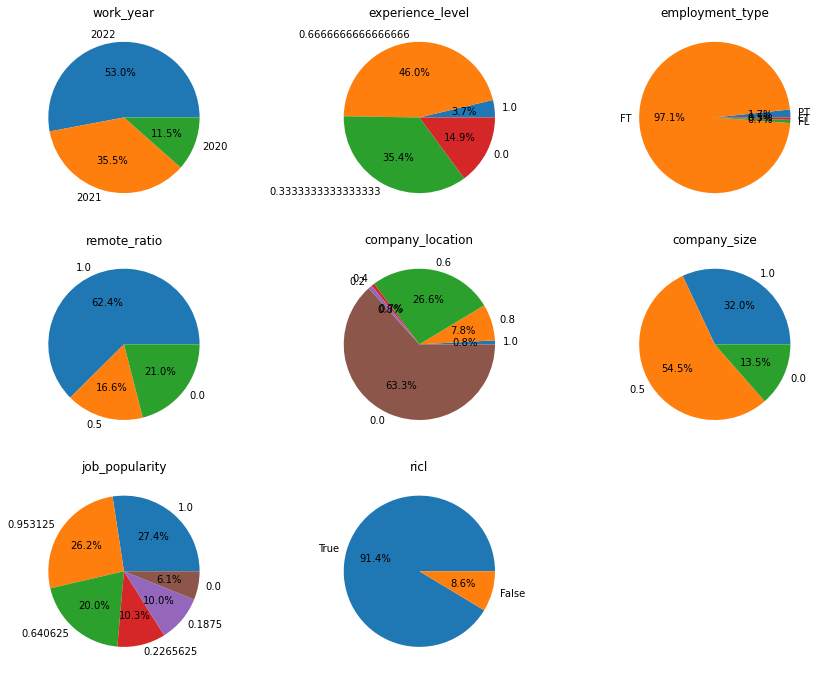

In [99]:
lv_X_cols = salaries.columns.drop("salary_in_usd")
salaries[lv_X_cols].apply(pie_maker(lv_X_cols.size, 3))
plt.show()

#### Drop

Cols w/ Low Variance will not help w/ Modelling

In [100]:
salaries.drop(columns="employment_type", inplace=True)

displayCols(salaries)

,col
0,work_year
1,experience_level
2,salary_in_usd
3,remote_ratio
4,company_location
5,company_size
6,job_popularity
7,ricl


## Feature Selection

### Correlation Analysis

If there exists a pair of strongly correlated cols $(|r|>0.7)$, either col can be used to accurately estimate the other, so only one of the pair will be needed.

However, as shown below, there are no strongly correlated cols

In [101]:
# Linear Correlation
pearson = salaries.corr()
# Rank Correlation
spearman = salaries.corr("spearman")

display(pearson.style.background_gradient(cmap="Reds"))
display(spearman.style.background_gradient(cmap="Reds"))

,work_year,experience_level,salary_in_usd,remote_ratio,company_location,company_size,job_popularity,ricl
work_year,1.000000,0.313639,0.289007,0.067835,-0.277007,-0.080334,0.038805,0.150223
experience_level,0.313639,1.000000,0.530218,0.089189,-0.352263,0.066641,-0.045435,0.066975
salary_in_usd,0.289007,0.530218,1.000000,0.143515,-0.559875,0.140546,-0.031816,0.156454
remote_ratio,0.067835,0.089189,0.143515,1.000000,-0.189412,-0.029430,-0.002138,-0.095203
company_location,-0.277007,-0.352263,-0.559875,-0.189412,1.000000,-0.030970,-0.044115,-0.054020
company_size,-0.080334,0.066641,0.140546,-0.029430,-0.030970,1.000000,0.027657,0.087340
job_popularity,0.038805,-0.045435,-0.031816,-0.002138,-0.044115,0.027657,1.000000,0.051363
ricl,0.150223,0.066975,0.156454,-0.095203,-0.054020,0.087340,0.051363,1.000000


,work_year,experience_level,salary_in_usd,remote_ratio,company_location,company_size,job_popularity,ricl
work_year,1.000000,0.326109,0.314161,0.118829,-0.295773,-0.153242,0.049796,0.166178
experience_level,0.326109,1.000000,0.557575,0.121280,-0.373028,0.027687,-0.018562,0.071662
salary_in_usd,0.314161,0.557575,1.000000,0.179842,-0.595832,0.109380,0.010792,0.166981
remote_ratio,0.118829,0.121280,0.179842,1.000000,-0.237075,-0.059444,0.033261,-0.089400
company_location,-0.295773,-0.373028,-0.595832,-0.237075,1.000000,-0.011855,-0.019441,-0.050173
company_size,-0.153242,0.027687,0.109380,-0.059444,-0.011855,1.000000,0.038068,0.070885
job_popularity,0.049796,-0.018562,0.010792,0.033261,-0.019441,0.038068,1.000000,0.020372
ricl,0.166178,0.071662,0.166981,-0.089400,-0.050173,0.070885,0.020372,1.000000


# Exports

## Write processed DF to csv file for future use

- not pkl since that is not presentable

In [102]:
salaries.to_csv("salaries_processed.csv")

## Store Mappers to convert from user inputs to data that models can understand

In [103]:
from json import JSONEncoder, dump

"""
Adapted from https://stackoverflow.com/a/67572570
np.bool_ data types cause dump to throw `TypeError: Object of type bool_ is not JSON serializable`
"""
class bool_JSONEncoder(JSONEncoder):
  def default(self, obj):
    return bool(obj) if isinstance(obj, np.bool_) else super().default(obj)

def Mapper(keys, series, sorter=lambda mapper: mapper):
  mapper = {}
  for i, v in enumerate(sorted(series.unique())):
    mapper[keys[i]] = v
  return sorter(mapper)

mappers = {
  "company_location": Mapper(["North America", "South America", "Africa", "Europe", "Asia", "Oceania"], salaries["company_location"]),
  "company_size": Mapper(["Less than 50 employees", "50 to 250 employees", "More than 250 employees"], salaries["company_size"]),
  "experience_level": Mapper(["Entry-level / Junior", "Mid-level / Intermediate", "Senior-level / Expert", "Executive-level / Director"], salaries["experience_level"]),
  "job_popularity": Mapper(["Manager", "ML Engineer", "Other", "Data Analyst", "Data Scientist", "Data Engineer"], salaries["job_popularity"]),
  "remote_ratio": Mapper(["Less than 20%", "20% to 80%", "More than 80%"], salaries["remote_ratio"]),
  "ricl": Mapper(["No", "Yes"], salaries["ricl"], lambda mapper: dict(sorted(mapper.items(), reverse=True)))
}

with open('../mappers.json', 'w') as f:
  dump(mappers, f, indent=2, cls=bool_JSONEncoder)